<a href="https://colab.research.google.com/github/WiratchawaKannika/API_LegalBERT-th/blob/main/AUC%2BROC_Evaluation_Prostate_Testprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Prostate_EffDet')
!pwd

/content/drive/MyDrive/Prostate_EffDet


# Installation

In [ ]:
!pip install numpy==1.17.5

In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0
!pip install glob2
!pip install --no-deps '/content/drive/MyDrive/Prostate_EffDet/timm-0.1.26-py3-none-any.whl'
!pip install --no-deps '/content/drive/MyDrive/Prostate_EffDet/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl'
#!pip install albumentations==0.4.6
!pip install -U albumentations

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 28.2MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
Processing ./timm-0.1.26-py3-none-any.whl
Processing ./pycocotools-2.0-cp37-cp37m-linux_x86_64.whl
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
     |████████████████████████████████| 102kB 3.2MB/s 
     |████████████████████████████████| 37.2MB 137kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# **Import Library**

In [ ]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/Prostate_EffDet/timm-efficientdet-pytorch")
sys.path.insert(0, "/content/drive/MyDrive/Prostate_EffDet/omegaconf")
sys.path.insert(0, "/content/drive/MyDrive/Prostate_EffDet/weightedboxesfusion")

from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader

import albumentations 
from albumentations.pytorch import ToTensorV2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

# Data preparation 

In [ ]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0) ,
        ], p=1.0)

In [ ]:
DATA_ROOT_PATH = '/content/drive/MyDrive/Prostate_EffDet/test' #train,test

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
dataset = DatasetRetriever(
    image_ids= np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    #batch_size=2,
    shuffle=False,
    #num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
print(len(data_loader))

10


## Load model

In [ ]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

# net = load_net('/content/drive/MyDrive/EffDet_project/Prostate_EffDet/Output_aug_kie2/best-checkpoint-045epoch.bin')
net = load_net('/content/drive/MyDrive/Prostate_EffDet/Output_aug_kie5/R2/last-checkpoint.bin')

## predictions function

In [ ]:
def make_predictions(images,  score_threshold : float):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).cuda().float())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

##  Non Max Suppression (NMS) function

In [ ]:
def nms_pytorch(boxes ,scores , thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """
    P = torch.tensor(boxes,  dtype=float)
    S = torch.tensor(scores, dtype=float)
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    scores = S

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
    
    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
  
    while len(order) > 0:
        
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep 

## Data .CSV file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Prostate_EffDet/prostate_test_mapping.csv')
print(len(df))
df.head()

19


,Unnamed: 0,Unnamed: 0.1,img_path,tagName,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,subset,fileName,x1,y1,x2,y2,class
0,0,0,/content/drive/MyDrive/Prostate_EffDet/test/pr...,prostate,https://irisprodseatraining.blob.core.windows....,468,309,81,58,0.524609,0.430187,0.090604,0.081944,test,prostate_custom_191.jpg,468.0,309.0,549.0,367.0,prostate
1,1,1,/content/drive/MyDrive/Prostate_EffDet/test/pr...,prostate,https://irisprodseatraining.blob.core.windows....,470,385,81,26,0.525727,0.535742,0.091723,0.036111,test,prostate_custom_191.jpg,470.0,385.0,551.0,411.0,prostate
2,2,2,/content/drive/MyDrive/Prostate_EffDet/test/pr...,prostate,https://irisprodseatraining.blob.core.windows....,351,374,39,58,0.393736,0.520464,0.043624,0.080556,test,prostate_custom_191.jpg,351.0,374.0,390.0,432.0,prostate
3,3,3,/content/drive/MyDrive/Prostate_EffDet/test/pr...,prostate,https://irisprodseatraining.blob.core.windows....,385,392,57,60,0.430804,0.544708,0.064732,0.083218,test,prostate_custom_194.jpg,385.0,392.0,442.0,452.0,prostate
4,4,4,/content/drive/MyDrive/Prostate_EffDet/test/pr...,prostate,https://irisprodseatraining.blob.core.windows....,512,362,32,41,0.572545,0.503099,0.035714,0.056865,test,prostate_custom_194.jpg,512.0,362.0,544.0,403.0,prostate


In [ ]:
#df = df.rename(columns={"img_path":"path"})
#df.head()

In [ ]:
# path_test = list(df['Path'])
# path =[]
# for i in path_test:
#     a = i.split('/')
#     m = '/content/drive/MyDrive/EffDet_project/Mammo/test/'+a[6]
#     path.append(m)
# df['Path'] = path

# Prediction

## Function for Evaluation

In [ ]:
# ''''Actual''

def ActualTeble(df):
    #เก็บค่า shape images
    list_shape_0 = []
    list_shape_1 = []
    img_path = sorted(list(set(df['img_path'])))
    for i in range(len(img_path)) :
        list_shape_0.append(cv2.imread(img_path[i]).shape[0])
        list_shape_1.append(cv2.imread(img_path[i]).shape[1])

    #เก็บค่า fileName และ จำนวนที่ซ้ำ *Non-duplicate 
    a = df.groupby(['fileName']).count()
    a = a.iloc[:,0]
    aa_ =[]
    for  i in  range(len(a)):
        aa = a[i]
        aa_.append(aa)
    name = sorted(list(set(df['fileName'])))

    #รวม actual box ใน 1 image 
    fileName_, x1s_, y1s_, x2s_, y2s_ =[], [], [], [], []
    for j in name:
        x1_, y1_, x2_, y2_ =[], [], [], []
        fileName_.append(j)
        for i in range(len(df)):
            fileName = df['fileName'][i] 
            if fileName == j:
                x1_.append(df['x1'][i])
                y1_.append(df['y1'][i])
                x2_.append(df['x2'][i])
                y2_.append(df['y2'][i])
        x1s_.append(x1_)
        y1s_.append(y1_)
        x2s_.append(x2_)
        y2s_.append(y2_)

    result = { 'fileName': fileName_, 'img_path':img_path, 'shape_0':list_shape_0, 'shape_1':list_shape_1, 'gt_xmin': x1s_,'gt_ymin': y1s_,'gt_xmax': x2s_,'gt_ymax': y2s_, 'count': aa_}
    result = pd.DataFrame(result, columns=['fileName', 'img_path', 'shape_0', 'shape_1', 'gt_xmin','gt_ymin','gt_xmax','gt_ymax', 'count'])

    return result

In [ ]:
# ''''Predict''''

def PredictTeble(test_df, result):
    #test_df คือ ตารางจากการ Prediction
    pred_xmin, pred_ymin,  pred_xmax, pred_ymax= [], [], [], []
    for i in range(len(test_df)) :
        x1_pre = test_df['xmin'][i]
        pred_xmin.append(x1_pre)
        y1_pre = test_df['ymin'][i]
        pred_ymin.append(y1_pre)
        x2_pre = test_df['xmax'][i]
        pred_xmax.append(x2_pre)
        y2_pre = test_df['ymax'][i]
        pred_ymax.append(y2_pre)

    result['pred_xmin'] = pred_xmin
    result['pred_ymin'] = pred_ymin
    result['pred_xmax'] = pred_xmax
    result['pred_ymax'] = pred_ymax

    #แก้ให้มันเก็บได้หลายค่า
    pred_xmins, pred_ymins ,pred_xmaxs, pred_ymaxs = [],[],[],[]
    for i in range(len(result)):
        Xmin,Ymin,Xmax,Ymax = [],[],[],[]
        for  j in range(len(result['pred_xmin'][i])):
            xmin = (result['pred_xmin'][i][j]/512)*result['shape_1'][i]
            ymin = (result['pred_ymin'][i][j]/512)*result['shape_0'][i]
            xmax= (result['pred_xmax'][i][j]/512)*result['shape_1'][i]
            ymax= (result['pred_ymax'][i][j]/512)*result['shape_0'][i]
            Xmin.append(xmin)
            Ymin.append(ymin)
            Xmax.append(xmax)
            Ymax.append(ymax)
        pred_xmins.append(Xmin)
        pred_ymins.append(Ymin)
        pred_xmaxs.append(Xmax)
        pred_ymaxs.append(Ymax)

    result['pred_xmin'] = pred_xmins
    result['pred_ymin'] = pred_ymins
    result['pred_xmax'] = pred_xmaxs
    result['pred_ymax'] = pred_ymaxs
    return result

In [ ]:
def IoUfunction(res):
  pre_ ,  gt_ = [], []
  i = 0

  for j in range(len(res['pred_xmin'].tolist()[i])):
    xmin_pre = int(res['pred_xmin'].tolist()[i][j])
    ymin_pre = int(res['pred_ymin'].tolist()[i][j])
    xmax_pre = int(res['pred_xmax'].tolist()[i][j])
    ymax_pre = int(res['pred_ymax'].tolist()[i][j])
    pre = [xmin_pre, ymin_pre, xmax_pre, ymax_pre]
    pre_.append(pre)

  for j in range(len(res['gt_xmin'].tolist()[i])):
    xmin_gt= int(res['gt_xmin'].tolist()[i][j])
    ymin_gt = int(res['gt_ymin'].tolist()[i][j])
    xmax_gt= int(res['gt_xmax'].tolist()[i][j])
    ymax_gt = int(res['gt_ymax'].tolist()[i][j])
    gt = [xmin_gt, ymin_gt, xmax_gt, ymax_gt]
    gt_.append(gt)
    
  #ป้องกัน ไม่มีผล predict
  if pre_ == []:
    iou_pred = torch.tensor([[0]], dtype=torch.float)
    iou_gt = torch.tensor([[0]], dtype=torch.float)
  else:
    box1 = torch.tensor(pre_, dtype=torch.float)
    box2 = torch.tensor(gt_, dtype=torch.float)
    iou_pred = bops.box_iou(box1, box2)
    iou_gt = bops.box_iou(box2, box1)

  return iou_pred, iou_gt

In [ ]:
import torch
import torchvision.ops.boxes as bops

def EvaluationTeble(result, threshold_iou):
    IoU_pred, IoUavg_img_ = [], []
    fileName = result['fileName'].tolist()

    TP, FP, TN, FN, Recall, Precision, FPR = [], [], [], [], [], [], []
    for i in fileName:
    
        #IoU Function
        res = result[result['fileName'] == i ]
        iou_pred, iou_gt = IoUfunction(res)

        '''Box Predict checking '''
        iou_PdGt_ = []
        IoUavg_im = []
        try:
            for i in range(len(iou_pred)):
                iou_PdGt = max(iou_pred[i])
                iou_PdGt_.append(iou_PdGt)
        except:
            iou_PdGt_ = torch.tensor([0], dtype=torch.float)
        # เก็บค่า 1,0 ถูก ผิด
        # threshold_iou = 0.5
        iou_pre_ =  []
        for i in range(len(iou_PdGt_)):
            pred_box = iou_PdGt_[i]
            '''1 . TP = number of detections with IoU>0.5 '''
            if pred_box  > threshold_iou :
                iou_pre = 1
                iou_pre_.append(iou_pre)
            else:
                ''' 2 . FP = number of detections with IoU<=0.5 or detected more than once '''
                iou_pre = 0
                iou_pre_.append(iou_pre)
        #TP,RP
        tp, fp =0, 0
        for i in list(set(iou_pre_)):
            if i ==1:
                tp = iou_pre_.count(i)
            else:
                fp = iou_pre_.count(i)

        ''' Box Actual checking '''
        #pred max
        iou_PdGt_ = []
        IoUavg_im = []
        try:
            for i in range(len(iou_gt)):
                iou_PdGt = max(iou_gt[i])
                iou_PdGt_.append(iou_PdGt)
        except:
                iou_PdGt_ = torch.tensor([0], dtype=torch.float)
        # เก็บค่า 1,0 ถูก ผิด
        # threshold_iou = 0.5
        iou_pre_ =  []
        for i in range(len(iou_PdGt_)):
            pred_box = iou_PdGt_[i]
            '''3 . TN= number of detections with IoU>0.5 '''
            if pred_box  > threshold_iou :
                iou_pre = 1
                iou_pre_.append(iou_pre)
            else:
                ''' 4 . FN = number of detections with IoU<=0.5 or detected more than once '''
                iou_pre = 0
                iou_pre_.append(iou_pre)
        #TN,FN
        tn, fn =0, 0
        for i in list(set(iou_pre_)):
            if i ==1:
                tn = iou_pre_.count(i)
            else:
                fn = iou_pre_.count(i)

            '''5. Duplicated BB are FP '''
            aa_ =[]
            for i in iou_gt:
                a_ =[]
                #print(i)
                try:
                    for j in i:
                        if j  > threshold_iou :
                            a_.append(1)
                        else:
                            a_.append(0)
                except:
                    if i  > threshold_iou :
                        a_.append(1)
                    else:
                        a_.append(0)
                aa_.append(a_)
            for i in aa_:
                num = i.count(1)
                if num >1:
                    num = i-1
                    fp = fp + num

            #calculate evaluation
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        fpr = fp/(tn+fp)

        TP.append(tp)
        FP.append(fp)
        TN.append(tn) 
        FN.append(fn) 
        Recall.append(recall) 
        Precision.append(precision)
        FPR.append(fpr)
        IoU_pred.append(iou_pred)


    result['IoU_img'] = IoU_pred
    result['TP'] = TP
    result['FP'] = FP
    result['FN'] = FN
    result['TN'] = TN
    result['Recall'] = Recall
    result['Precision'] = Precision
    result['FPR'] = FPR 


    return result

In [ ]:
#แก้ให้มีหลายรูป
def Multipredictions(data_loader, score_threshold, thresh_iou):
    results = []
    for images, image_ids in data_loader:
        predictions = make_predictions(images,score_threshold)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=511)
            image_id = image_ids[i]

            box = nms_pytorch(boxes ,scores , thresh_iou)
            Xmin,Ymin,Xmax,Ymax = [],[],[],[]
            for  i in range(len(box)):
                xmin= float(box[i][0])
                ymin = float(box[i][1])
                xmax= float(box[i][2])
                ymax= float(box[i][3])
                Xmin.append(xmin)
                Ymin.append(ymin)
                Xmax.append(xmax)
                Ymax.append(ymax)
            result = {
                'image_id': image_id,
                'xmin': Xmin,
                'ymin' : Ymin,
                'xmax': Xmax,
                'ymax': Ymax
                }
        results.append(result)

    test_df = pd.DataFrame(results, columns=['image_id', 'xmin', 'ymin', 'xmax', 'ymax'])
    test_df = test_df.sort_values("image_id").reset_index(drop=True)

    return test_df

## AUC curve 

### Finding best threshold Score  box

In [ ]:
threshold_score = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
precision, recall, threshold = [], [], []
for i in  range(len(threshold_score)):
    thresh_iou = 0.1
    threshold_iou = 0.5
    score_threshold = threshold_score[i]
    test_df = Multipredictions(data_loader, score_threshold, thresh_iou)
    result= ActualTeble(df)
    result = PredictTeble(test_df, result)
    result = EvaluationTeble(result,threshold_iou)
    if np.mean(result.Precision) == 0 and np.mean(result.Recall) == 0:
        print(True)
    else:
        precision.append(np.mean(result.Precision))
        recall.append(np.mean(result.Recall))
        threshold.append(threshold_score[i])
i = np.arange(len(precision))
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision, index = i),'Recall' : pd.Series(recall, index = i)})
roc0

True


,Threshold,Precision,Recall
0,0.0,0.044978,0.616667
1,0.1,0.573333,0.533333
2,0.2,0.416667,0.300000
3,0.3,0.450000,0.300000
4,0.4,0.500000,0.300000
5,0.5,0.400000,0.250000
6,0.6,0.400000,0.216667
7,0.7,0.400000,0.216667
8,0.8,0.200000,0.150000
9,0.9,0.200000,0.150000


In [ ]:
fix_value = [{'Threshold':1.000,'Precision':1.000,'Recall':0.000}]
roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
roc0 = roc0.apply(np.roll, shift=-1) #move he last row to the first

roc0 = roc0.sort_values(by='Threshold', ascending=True)
fix_value = [{'Threshold':0.000,'Precision':0.000,'Recall':1.000}]
roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
roc0 = roc0.apply(np.roll, shift=1) #move he last row to the first
roc0

,Threshold,Precision,Recall
0,0.0,0.000000,1.000000
1,0.0,0.044978,0.616667
2,0.1,0.573333,0.533333
3,0.2,0.416667,0.300000
4,0.3,0.450000,0.300000
5,0.4,0.500000,0.300000
6,0.5,0.400000,0.250000
7,0.6,0.400000,0.216667
8,0.7,0.400000,0.216667
9,0.8,0.200000,0.150000


In [ ]:
recall = roc0.Recall
precision = roc0.Precision
from sklearn.metrics import auc
area = auc(recall, precision)
print("Area Under Curve: %0.2f" % area)

Area Under Curve: 0.30


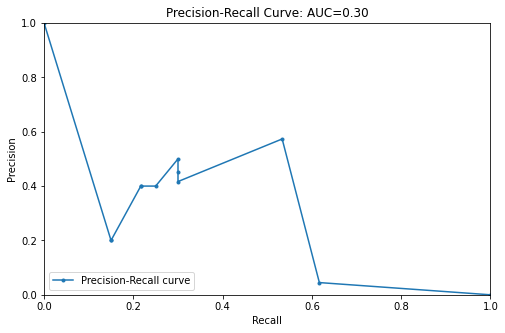

In [ ]:
from matplotlib import pyplot
fig=pyplot.figure(figsize=(8, 5))
pyplot.clf()
pyplot.plot(recall, precision, marker='.', label='Precision-Recall curve')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.ylim([0.0, 1.0])
pyplot.xlim([0.0, 1.0])
pyplot.title('Precision-Recall Curve: AUC=%0.2f' % area)
pyplot.legend(loc="lower left")
pyplot.show()

## ROC curve 

In [ ]:
threshold_score = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
fpr, tpr, threshold = [], [], []
for i in  range(len(threshold_score)):
    thresh_iou = 0.1
    threshold_iou = 0.5
    score_threshold = threshold_score[i]
    test_df = Multipredictions(data_loader, score_threshold, thresh_iou)
    result= ActualTeble(df)
    result = PredictTeble(test_df, result)
    result = EvaluationTeble(result,threshold_iou)
    if np.mean(result.FPR) == 0 and np.mean(result.Recall) == 0:
        print(True)
    else:
        fpr.append(np.mean(result.FPR))
        tpr.append(np.mean(result.Recall))
        threshold.append(threshold_score[i])
i = np.arange(len(fpr))
roc1 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'FPR' : pd.Series(fpr, index = i),'TPR' : pd.Series(tpr, index = i)})
roc1

,Threshold,FPR,TPR
0,0.0,0.955022,0.616667
1,0.1,0.426667,0.533333
2,0.2,0.583333,0.300000
3,0.3,0.550000,0.300000
4,0.4,0.500000,0.300000
5,0.5,0.600000,0.250000
6,0.6,0.600000,0.216667
7,0.7,0.600000,0.216667
8,0.8,0.800000,0.150000
9,0.9,0.800000,0.150000


In [ ]:
roc1 = roc1.sort_values(by='Threshold', ascending=True)
roc1

,Threshold,FPR,TPR
0,0.0,0.955022,0.616667
1,0.1,0.426667,0.533333
2,0.2,0.583333,0.300000
3,0.3,0.550000,0.300000
4,0.4,0.500000,0.300000
5,0.5,0.600000,0.250000
6,0.6,0.600000,0.216667
7,0.7,0.600000,0.216667
8,0.8,0.800000,0.150000
9,0.9,0.800000,0.150000


In [ ]:
tpr = roc1.TPR
fpr = roc1.FPR
from sklearn.metrics import auc
area = auc(tpr, fpr)
print("AUC for ROC curve : %0.2f" % area)

AUC for ROC curve : 0.40


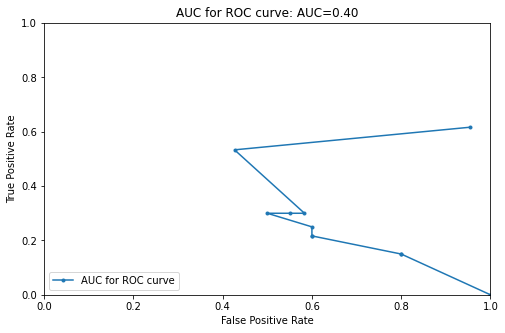

In [ ]:
from matplotlib import pyplot
fig=pyplot.figure(figsize=(8, 5))
pyplot.clf()
pyplot.plot(fpr, tpr, marker='.', label='AUC for ROC curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.ylim([0.0, 1.0])
pyplot.xlim([0.0, 1.0])
pyplot.title('AUC for ROC curve: AUC=%0.2f' % area)
pyplot.legend(loc="lower left")
pyplot.show()

> # เลือก  Threshold

## Selection Best Threshold

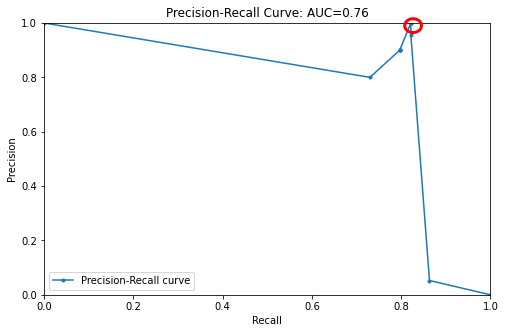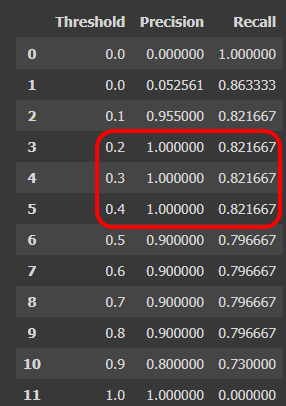

# Result

In [ ]:
score_threshold = 0.1 # 0.2,0.3,0.4 ได้หมดทั้ง 3 threshold
thresh_iou = 0.1 #setting by me!
threshold_iou = 0.5 #setting by me!

In [ ]:
test_df = Multipredictions(data_loader, score_threshold, thresh_iou)
result= ActualTeble(df)
result = PredictTeble(test_df, result)
result = EvaluationTeble(result,threshold_iou)

### Show Performance Result

In [ ]:
print('\n', 'Precision: ', result.Precision.tolist(),'\n', '*Avg. Score:', np.mean(result.Precision))
print('\n', 'Recall: ', result.Recall.tolist(),'\n', '*Avg. Score:', np.mean(result.Recall))


 Precision:  [0.5, 0.5, 0.0, 0.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.4] 
 *Avg. Score: 0.5733333333333334

 Recall:  [0.3333333333333333, 0.5, 0.0, 0.0, 0.5, 1.0, 1.0, 0.3333333333333333, 1.0, 0.6666666666666666] 
 *Avg. Score: 0.5333333333333333


In [ ]:
result

,fileName,img_path,shape_0,shape_1,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,IoU_img,TP,FP,FN,TN,Recall,Precision,FPR
0,prostate_custom_191.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,"[455.73046875, 480.17578125]","[333.28125, 388.125]","[499.3828125, 543.03515625]","[383.90625, 423.28125]","[[tensor(0.1804), tensor(0.), tensor(0.)], [te...",1,1,2,1,0.333333,0.500000,0.500000
1,prostate_custom_194.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,"[383.25, 439.25]","[394.296875, 283.048828125]","[453.25, 514.5]","[449.216796875, 373.173828125]","[[tensor(0.7582), tensor(0.)], [tensor(0.), te...",1,1,1,1,0.500000,0.500000,0.500000
2,prostate_custom_196.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,[572.0],[408.0],[614.0],[501.0],1,[],[],[],[],[[tensor(0.)]],0,1,1,0,0.000000,0.000000,1.000000
3,prostate_custom_197.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,895,[437.0],[382.0],[518.0],[430.0],1,"[379.326171875, 498.193359375]","[379.6875, 286.875]","[428.271484375, 520.91796875]","[430.3125, 317.8125]","[[tensor(0.)], [tensor(0.)]]",0,2,1,0,0.000000,0.000000,1.000000
4,prostate_custom_198.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,[515.09765625],[367.03125],[550.01953125],[407.8125],"[[tensor(0.), tensor(0.5186)]]",1,0,1,1,0.500000,1.000000,0.000000
5,prostate_custom_200.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,[403.0],[208.0],[462.0],[240.0],1,[404.25],[199.96484375],[463.75],[235.169921875],[[tensor(0.6402)]],1,0,0,1,1.000000,1.000000,0.000000
6,prostate_custom_201.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[413.0, 464.0]","[291.0, 294.0]","[445.0, 501.0]","[319.0, 327.0]",2,"[460.96875, 412.078125]","[285.46875, 288.28125]","[506.3671875, 452.23828125]","[324.84375, 324.84375]","[[tensor(0.), tensor(0.5827)], [tensor(0.6222)...",2,0,0,2,1.000000,1.000000,0.000000
7,prostate_custom_203.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,895,"[437.0, 420.0, 411.0]","[313.0, 386.0, 250.0]","[475.0, 461.0, 458.0]","[359.0, 408.0, 293.0]",3,"[435.263671875, 424.775390625, 433.515625]","[305.15625, 390.9375, 272.8125]","[494.697265625, 450.99609375, 456.240234375]","[357.1875, 413.4375, 295.3125]","[[tensor(0.5318), tensor(0.), tensor(0.)], [te...",1,2,2,1,0.333333,0.333333,0.666667
8,prostate_custom_206.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,[371.0],[352.0],[429.0],[404.0],1,[366.6796875],[350.15625],[429.5390625],[392.34375],[[tensor(0.6942)]],1,0,0,1,1.000000,1.000000,0.000000
9,prostate_custom_207.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[363.0, 503.0, 447.0]","[312.0, 322.0, 407.0]","[410.0, 532.0, 512.0]","[372.0, 372.0, 439.0]",3,"[447.0, 356.203125, 471.4453125, 419.0625, 408...","[396.5625, 315.0, 355.78125, 293.90625, 405.0]","[516.84375, 401.6015625, 515.09765625, 466.207...","[440.15625, 371.25, 381.09375, 327.65625, 437....","[[tensor(0.), tensor(0.), tensor(0.6851)], [te...",2,3,1,2,0.666667,0.400000,0.600000


# True Positive

In [ ]:
number_gt = result['count'].tolist()
TP = result['TP'].tolist()
print('Bbox Ground Truth: ' ,sum(number_gt))
print('True Positive: ' ,sum(TP))
print('Accuracy: ', sum(TP)/sum(number_gt))

Bbox Ground Truth:  19
True Positive:  10
Accuracy:  0.5263157894736842


# Function หา TP

#### Add Bank Columns

In [ ]:
result['True'] = ' '
#result['False'] = ' '

In [ ]:
result.head()

,fileName,img_path,shape_0,shape_1,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,IoU_img,TP,FP,FN,Recall,Precision,True
0,prostate_custom_191.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,"[459.22265625, 494.14453125]","[270.0, 340.3125]","[544.78125, 555.2578125]","[348.75, 393.75]","[[tensor(0.3544), tensor(0.), tensor(0.)], [te...",0,2,3,0.0,0.000000,
1,prostate_custom_194.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,"[441.0, 507.5, 381.5]","[278.82421875, 333.744140625, 402.74609375]","[521.5, 542.5, 458.5]","[375.990234375, 390.072265625, 449.216796875]","[[tensor(0.), tensor(0.0131)], [tensor(0.), te...",1,2,1,0.5,0.333333,
2,prostate_custom_196.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,[572.0],[408.0],[614.0],[501.0],1,[],[],[],[],[[tensor(0.)]],0,1,1,0.0,0.000000,
3,prostate_custom_197.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,895,[437.0],[382.0],[518.0],[430.0],1,[377.578125],[379.6875],[424.775390625],[428.90625],[[tensor(0.)]],0,1,1,0.0,0.000000,
4,prostate_custom_198.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,[],[],[],[],[[tensor(0.)]],0,1,1,0.0,0.000000,


In [ ]:
def get_TF(iou_img) :
    bbox1 = []
    bbox2 = []
    bbox3 = []
    #print('จำนวน Bbox จริง:', iou_img.shape[1])
    for i in range(len(iou_img)) :
        if  iou_img.shape[1] == 1 :
            box1 = float(iou_img[i])
            bbox1.append(box1)
        elif iou_img.shape[1] == 2 :
            box1 = float(iou_img[i][0])
            bbox1.append(box1)
            box2 = float(iou_img[i][1])
            bbox2.append(box2)
        else:
            box1 = float(iou_img[i][0])
            bbox1.append(box1)
            box2 = float(iou_img[i][1])
            bbox2.append(box2)
            box3 = float(iou_img[i][2])
            bbox3.append(box3)

    T = []
    F = []
    max_list = []
    if iou_img.shape[1] == 1 :
        max1 = max(bbox1)
        max_list.append(max1)
    elif iou_img.shape[1] == 2 :
        max1 = max(bbox1)
        max_list.append(max1)
        max2 = max(bbox2)
        max_list.append(max2)
    else:
        max1 = max(bbox1)
        max_list.append(max1)
        max2 = max(bbox2)
        max_list.append(max2)
        max3 = max(bbox3)
        max_list.append(max3)

    for j in max_list :
        if j >= 0.5 :
          T.append('T')
        else:
          F.append('F')

    return T, F

#### Evaluation แบบคุณหมอ

In [ ]:
Tru, Fla = [], []
for i in range(len(result['IoU_img'])):
    t, f = get_TF(result['IoU_img'][i])
    Tru.append(len(t))
    Fla.append(len(f))

result['True'] = Tru
#result['False'] = Fla

In [ ]:
result

,fileName,img_path,shape_0,shape_1,gt_xmin,gt_ymin,gt_xmax,gt_ymax,count,pred_xmin,pred_ymin,pred_xmax,pred_ymax,IoU_img,TP,FP,FN,Recall,Precision,True
0,prostate_custom_191.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[468.0, 470.0, 351.0]","[309.0, 385.0, 374.0]","[549.0, 551.0, 390.0]","[367.0, 411.0, 432.0]",3,"[459.22265625, 494.14453125]","[270.0, 340.3125]","[544.78125, 555.2578125]","[348.75, 393.75]","[[tensor(0.3544), tensor(0.), tensor(0.)], [te...",0,2,3,0.000000,0.000000,0
1,prostate_custom_194.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,"[385.0, 512.0]","[392.0, 362.0]","[442.0, 544.0]","[452.0, 403.0]",2,"[441.0, 507.5, 381.5]","[278.82421875, 333.744140625, 402.74609375]","[521.5, 542.5, 458.5]","[375.990234375, 390.072265625, 449.216796875]","[[tensor(0.), tensor(0.0131)], [tensor(0.), te...",1,2,1,0.500000,0.333333,1
2,prostate_custom_196.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,[572.0],[408.0],[614.0],[501.0],1,[],[],[],[],[[tensor(0.)]],0,1,1,0.000000,0.000000,0
3,prostate_custom_197.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,895,[437.0],[382.0],[518.0],[430.0],1,[377.578125],[379.6875],[424.775390625],[428.90625],[[tensor(0.)]],0,1,1,0.000000,0.000000,0
4,prostate_custom_198.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[510.0, 527.0]","[436.0, 362.0]","[544.0, 553.0]","[475.0, 404.0]",2,[],[],[],[],[[tensor(0.)]],0,1,1,0.000000,0.000000,0
5,prostate_custom_200.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,721,896,[403.0],[208.0],[462.0],[240.0],1,[],[],[],[],[[tensor(0.)]],0,1,1,0.000000,0.000000,0
6,prostate_custom_201.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[413.0, 464.0]","[291.0, 294.0]","[445.0, 501.0]","[319.0, 327.0]",2,[455.73046875],[288.28125],[506.3671875],[337.5],"[[tensor(0.), tensor(0.4886)]]",0,1,2,0.000000,0.000000,0
7,prostate_custom_203.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,895,"[437.0, 420.0, 411.0]","[313.0, 386.0, 250.0]","[475.0, 461.0, 458.0]","[359.0, 408.0, 293.0]",3,"[464.98046875, 430.01953125, 442.255859375]","[302.34375, 388.125, 254.53125]","[498.193359375, 457.98828125, 470.224609375]","[351.5625, 410.625, 291.09375]","[[tensor(0.1395), tensor(0.), tensor(0.)], [te...",1,2,2,0.333333,0.333333,1
8,prostate_custom_206.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,[371.0],[352.0],[429.0],[404.0],1,[366.6796875],[348.75],[429.5390625],[388.125],[[tensor(0.6056)]],1,0,0,1.000000,1.000000,1
9,prostate_custom_207.jpg,/content/drive/MyDrive/Prostate_EffDet/test/pr...,720,894,"[363.0, 503.0, 447.0]","[312.0, 322.0, 407.0]","[410.0, 532.0, 512.0]","[372.0, 372.0, 439.0]",3,"[354.45703125, 466.20703125]","[315.0, 358.59375]","[403.34765625, 518.58984375]","[368.4375, 430.3125]","[[tensor(0.6430), tensor(0.), tensor(0.)], [te...",1,1,2,0.333333,0.500000,1


In [ ]:
number_gt = result['count'].tolist()
TP = result['True'].tolist()
print('Bbox Ground Truth: ' ,sum(number_gt))
print('True Positive: ' ,sum(TP))
print('Accuracy: ', sum(TP)/sum(number_gt))

Bbox Ground Truth:  19
True Positive:  4
Accuracy:  0.21052631578947367


#Plot img Prediction

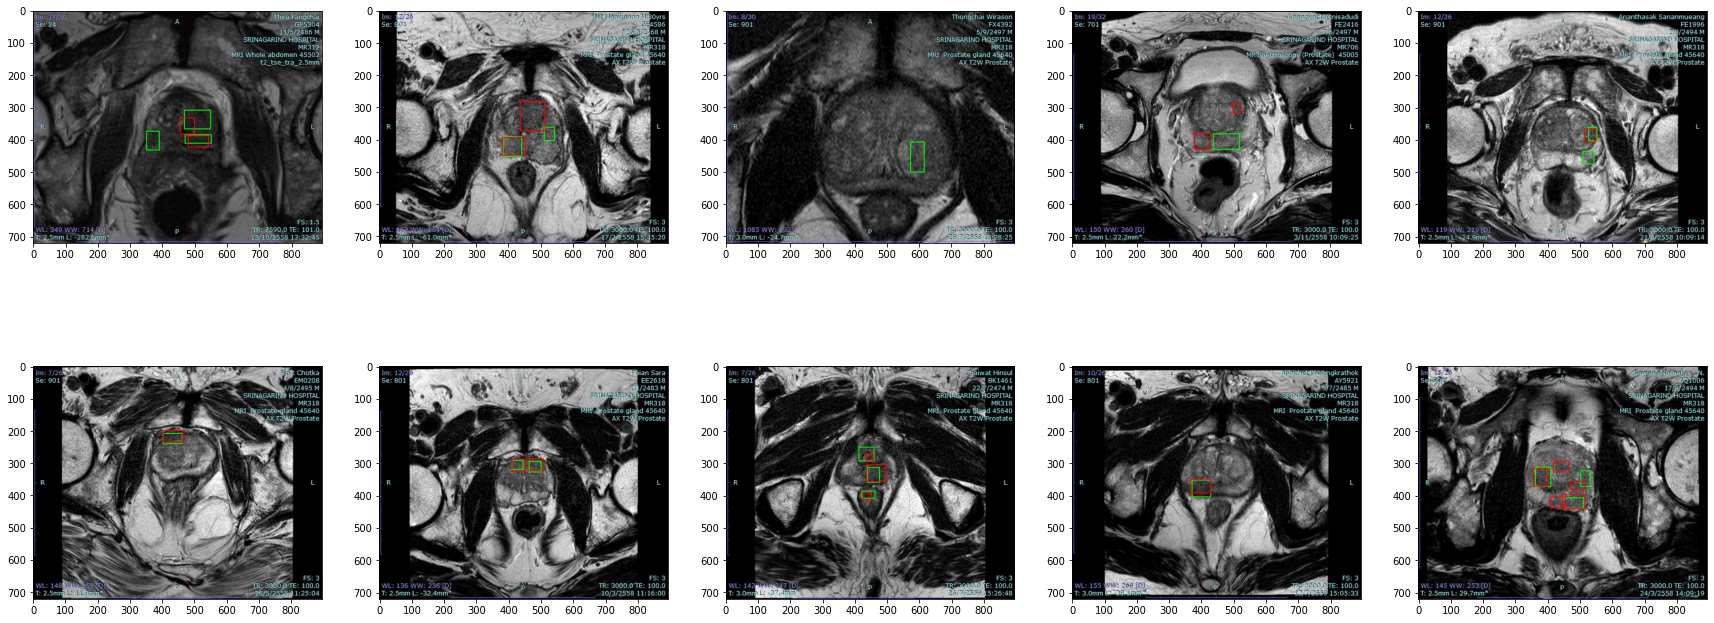

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 20
h = 20
fig = plt.figure(figsize=(30, 12))
columns = 5
rows = 2

fileName = result['fileName'].tolist()
for m in range(1, columns*rows +1):
    res = result[result['fileName'] ==fileName[m-1]]

    i = 0
    #load image origin save to test.jpg
    import cv2
    from IPython.display import Image
    img_path = res['img_path'].tolist()[0]
    img_c = cv2.imread(img_path)

    for j in range(len(res['gt_xmin'].tolist()[i])):
        xmin_pre = int(res['gt_xmin'].tolist()[i][j])
        ymin_pre = int(res['gt_ymin'].tolist()[i][j])
        xmax_pre = int(res['gt_xmax'].tolist()[i][j])
        ymax_pre = int(res['gt_ymax'].tolist()[i][j])
        if j == 0:
            image_pre = cv2.rectangle(img_c, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 2)
        else:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 2)

    for j in range(len(res['pred_xmin'].tolist()[i])):
        xmin_pre = int(res['pred_xmin'].tolist()[i][j])
        ymin_pre = int(res['pred_ymin'].tolist()[i][j])
        xmax_pre = int(res['pred_xmax'].tolist()[i][j])
        ymax_pre = int(res['pred_ymax'].tolist()[i][j])
        if j == 0:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 2)
        else:
            image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 2)

    fig.add_subplot(rows, columns, m)
    plt.imshow(image_pre)
plt.show()

### AUC curve 

In [ ]:
roc0 = result[['fileName','Recall', 'Precision']]
roc0 = roc0.sort_values(by='Recall', ascending=True)
recall = roc0.Recall
precision = roc0.Precision

from sklearn.metrics import auc
area = auc(recall, precision)
print("Area Under Curve: %0.2f" % area)

Area Under Curve: 0.50


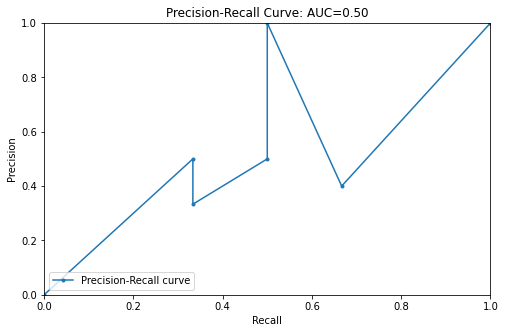

In [ ]:
from matplotlib import pyplot
fig=pyplot.figure(figsize=(8, 5))
pyplot.clf()
pyplot.plot(recall, precision, marker='.', label='Precision-Recall curve')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.ylim([0.0, 1.0])
pyplot.xlim([0.0, 1.0])
pyplot.title('Precision-Recall Curve: AUC=%0.2f' % area)
pyplot.legend(loc="lower left")
pyplot.show()

### ROC curve 

In [ ]:
roc1 = result[['fileName','FPR', 'Recall']]
roc1 = roc1.sort_values(by='FPR', ascending=True)
TPR = roc1.Recall
FPR = roc1.FPR

from sklearn.metrics import auc
area1 = auc(FPR, TPR)
print("AUC for ROC curve: %0.2f" % area1)

AUC for ROC curve: 0.48


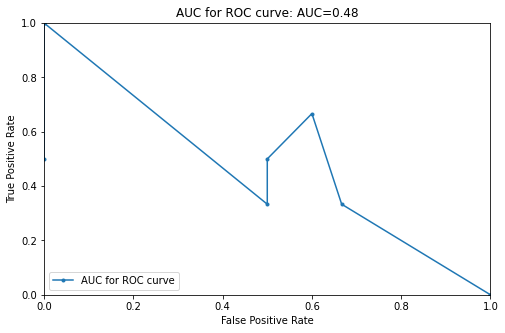

In [ ]:
from matplotlib import pyplot
fig=pyplot.figure(figsize=(8, 5))
pyplot.clf()
pyplot.plot(FPR, TPR, marker='.', label='AUC for ROC curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.ylim([0.0, 1.0])
pyplot.xlim([0.0, 1.0])
pyplot.title('AUC for ROC curve: AUC=%0.2f' % area1)
pyplot.legend(loc="lower left")
pyplot.show()

## Testing Step 5. Duplicated BB are FP

In [ ]:
result['fileName'] 

0    prostate_custom_191.jpg
1    prostate_custom_194.jpg
2    prostate_custom_196.jpg
3    prostate_custom_197.jpg
4    prostate_custom_198.jpg
5    prostate_custom_200.jpg
6    prostate_custom_201.jpg
7    prostate_custom_203.jpg
8    prostate_custom_206.jpg
9    prostate_custom_207.jpg
Name: fileName, dtype: object

In [ ]:
  res = result[result['fileName'] == 'mammo_189.jpg']
  iou_pred, iou_gt = IoUfunction(res)
  print(iou_gt)
  '''Box Predict checking '''
  iou_PdGt_ = []
  IoUavg_im = []
  try:
    for i in range(len(iou_pred)):
      iou_PdGt = max(iou_pred[i])
      iou_PdGt_.append(iou_PdGt)
  except:
    iou_PdGt_ = torch.tensor([0], dtype=torch.float)
  # เก็บค่า 1,0 ถูก ผิด
  threshold_iou = 0.5
  iou_pre_ =  []
  for i in range(len(iou_PdGt_)):
    pred_box = iou_PdGt_[i]
    '''1 . TP = number of detections with IoU>0.5 '''
    if pred_box  > threshold_iou :
      iou_pre = 1
      iou_pre_.append(iou_pre)
    else:
      ''' 2 . FP = number of detections with IoU<=0.5 or detected more than once '''
      iou_pre = 0
      iou_pre_.append(iou_pre)
  #TP,RP
  tp, fp =0, 0
  for i in list(set(iou_pre_)):
    if i ==1:
      tp = iou_pre_.count(i)
    else:
      fp = iou_pre_.count(i)

  ''' Box Actual checking '''
  #pred max
  iou_PdGt_ = []
  IoUavg_im = []
  try:
    for i in range(len(iou_gt)):
      iou_PdGt = max(iou_gt[i])
      iou_PdGt_.append(iou_PdGt)
  except:
    iou_PdGt_ = torch.tensor([0], dtype=torch.float)
  # เก็บค่า 1,0 ถูก ผิด
  threshold_iou = 0.5
  iou_pre_ =  []
  for i in range(len(iou_PdGt_)):
    pred_box = iou_PdGt_[i]
    '''3 . TN= number of detections with IoU>0.5 '''
    if pred_box  > threshold_iou :
      iou_pre = 1
      iou_pre_.append(iou_pre)
    else:
      ''' 4 . FN = number of detections with IoU<=0.5 or detected more than once '''
      iou_pre = 0
      iou_pre_.append(iou_pre)
  #TN,FN
  tn, fn =0, 0
  for i in list(set(iou_pre_)):
    if i ==1:
      tn = iou_pre_.count(i)
    else:
      fn = iou_pre_.count(i)

    '''5. Duplicated BB are FP '''
    aa_ =[]
    for i in iou_gt:
        a_ =[]
        #print(i)
        try:
            for j in i:
                if j  > threshold_iou :
                    a_.append(1)
                else:
                    a_.append(0)
        except:
            if i  > threshold_iou :
                a_.append(1)
            else:
                a_.append(0)
        aa_.append(a_)

    for i in aa_:
        num = i.count(1)
        print(num)
        if num >1:
            num = i-1
            fp = fp + num
  #print()
    #calculate evaluation
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)

  print(tp,fp,tn,fn)

IndexError: ignored

In [ ]:
## <Threshold_IoU = 0.2 

In [ ]:
i = 0
#load image origin save to test.jpg
import cv2
from IPython.display import Image
img_path = res['Path'].tolist()[0]
img_c = cv2.imread(img_path)

for j in range(len(res['gt_xmin'].tolist()[i])):
  xmin_pre = int(res['gt_xmin'].tolist()[i][j])
  ymin_pre = int(res['gt_ymin'].tolist()[i][j])
  xmax_pre = int(res['gt_xmax'].tolist()[i][j])
  ymax_pre = int(res['gt_ymax'].tolist()[i][j])
  if j == 0:
    image_pre = cv2.rectangle(img_c, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 1)
  else:
    image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (0,255,0), 1)

for j in range(len(res['pred_xmin'].tolist()[i])):
  xmin_pre = int(res['pred_xmin'].tolist()[i][j])
  ymin_pre = int(res['pred_ymin'].tolist()[i][j])
  xmax_pre = int(res['pred_xmax'].tolist()[i][j])
  ymax_pre = int(res['pred_ymax'].tolist()[i][j])
  if j == 0:
    image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 1)
  else:
    image_pre = cv2.rectangle(image_pre, (xmin_pre ,ymin_pre), (xmax_pre, ymax_pre), (255, 0, 0), 1)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.imshow(image_pre)

In [ ]:
!nvidia-smi

Tue Jul  6 08:09:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------